
# EP1 de Programacao Paralela e distribuida - MAC5742
## Analise dos Resultados


| Nome | NUSP |
|------|------|
| Ariel Serranoni Soares da Silva| 7658024 |
| Thiago Martinoni | Numero usp |


### Resumo
Em Topologia, um conjunto é auto 
A implementação sequencial  é muito comum em disciplinas introdutórias de computação. Neste trabalho vamos além, implementaremos três versões deste algorítmo, a clássica sequencial, uma utilizando pthreads e uma terceira utilizando open mp. Os códigos em C e seus encontram-se disponíveis em bla. Aqui vamos analisar o desempenho de cada algorítmo afim de obter um parâmetro de comparação a respeito do 
desempenho dessas bibliotecas.

### Implementações em C

Temos três arquivos, cada um responsável por calcular o conjunto de mandelbrot utilizando um método diferente. 
O Programa mandelbrot_seq serve como base para os outros dois. 
Notando que cada iteração do loop exterior na função compute_mandelbrot é responsável por produzir uma linha completa da imagem
final e que cada linha é independente. adotamos isso como unidade elementar e distribuímos o trabalho entre múltiplas threads

Nas implementações em paralelo, utilizamos a estratégia de divisão estática
tanto no programa mandelbrot_pth quanto no mandelbrot_omp afim de obter uma comparação mais justa possível. Por isso deixamos todas as varíavei

Quando o usuário solicita um número maior de threads do que de linhas na imagem
Medições de tempo e output usamos do EP anterior.

### Infra estrutura Julia

Para este relatório, usamos jupyter notebooks e Julia, conforme nos eps anteriores. Também usamos os mesmos pacotes e muitas das funções do nosso último trabalho adaptadas ao novo problema. A seguinte célula fará as instalações de pacotes julia  

In [1]:
]up

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/ariel-ep1-paralela/src/Project.toml`
 [no changes]
  Updating `~/ariel-ep1-paralela/src/Manifest.toml`
 [no changes]


In [2]:
using Pkg 
Pkg.build("FFTW")

  Building FFTW → `~/.julia/packages/FFTW/5DZuu/deps/build.log`


false

In [3]:
] st

    Status `~/ariel-ep1-paralela/src/Project.toml`
  [336ed68f] CSV v0.6.2
  [a93c6f00] DataFrames v0.21.1
  [31c24e10] Distributions v0.23.3
  [7073ff75] IJulia v1.21.2
  [8314cec4] PGFPlotsX v1.2.6
  [1a8c2f83] Query v0.12.2
  [f3b207a7] StatsPlots v0.14.6


### Experimentos

O Primeiro passo para analisarmos o tempo de execução de um determinado programa sempre foi e sempre será executar o programa
em questão. A função abaixo é uma adaptação da função `blá`, do mini EP3. Seu objetivo é justamente fazer uma chamada na linha de comando e salva alguns dados.


In [2]:
using DataFrames, Query, StatsPlots, Statistics

function mandelbrot(method, region, image_size, threads=1)
    a=region[2][1]
    b=region[2][2]
    c=region[2][3]
    d=region[2][4]
    results = parse.(Float64,
        split(chomp(read(`./mandelbrot_$method $a  $b $c $d $image_size $threads`, String)), ", "))
        
    return DataFrame(size = image_size,
                region=region[1],
                delta_x = region[2][2] - region[2][1],
                delta_y = region[2][4] - region[2][3],
                duration_clock = results[1],
                duration_mono = results[2],
                duration_sys = results[3],
                threads=threads,
                method=method)
    end

mandelbrot (generic function with 2 methods)

Para que nossa análise tenha alguma importância do ponto de vista estatístico, precisamos nos basear em um número consideravelmente grande de execuções do programa. A função a seguir, também adaptada do miniEP3 tem o intuito de automatizar 
repetidas chamadas dos programas em C, feitas pela função acima, coletar os resultados e retorná-los na forma de um DataFrame.

In [4]:
function run_experiments(methods, regions ,image_size, threads, repetitions)
    run(`make`)
    
    results = DataFrame(size = Int64[],
                region = String[],
                delta_x = Float64[],
                delta_y = Float64[],
                duration_clock = Float64[],
                duration_mono = Float64[],
                duration_sys = Float64[],
                threads= Int64[],
                method= String[])
    
    for tuple in regions
        for method in methods
            for size in image_size
                for t in 1:length(threads)
                    if (threads[t] <= 1 || method != "seq") 
                        for r in 1:repetitions
                            append!(results, mandelbrot(method, tuple, size, threads[t]))
                
                        end
                    end
                end
            end
        end
    end
    return results
end

run_experiments (generic function with 1 method)

In [6]:
function parse_results(results)
  parsed_results=results|>
                @groupby((_.threads,_.method,_.region)) |>
                @map({threads_method = key(_),
                repetitions=repetitions,
                size = mean(_.size),
                delta_x = mean(_.delta_x),
                delta_y = mean(_.delta_y),
                mean_duration_clock = mean(_.duration_clock),
                mean_duration_mono = mean(_.duration_mono),
                mean_duration_sys = mean(_.duration_sys),
                ci_duration_clock = 1.96 * std(_.duration_clock),
                ci_duration_mono = 1.96 * std(_.duration_mono),
                ci_duration_sys = 1.96 * std(_.duration_sys)})|>
                DataFrame
    
      final_results = DataFrame(threads= Int64[],
                    method= String[],
                    region = String[],
                    size = Int64[],
                    delta_x = Float64[],
                    delta_y = Float64[],
                    mean_duration_clock = Float64[],
                    mean_duration_mono = Float64[],
                    mean_duration_sys = Float64[],
                    ci_duration_clock = Float64[],
                    ci_duration_mono = Float64[],
                    ci_duration_sys = Float64[],
                    repetitions = Int64[])
    
        for i in 1:length(parsed_results.size)
            
            append!(final_results, DataFrame(size=parsed_results.size[i],
                                        delta_x=parsed_results.delta_x[i],
                                         delta_y=parsed_results.delta_y[i],
                                        mean_duration_clock=parsed_results.mean_duration_clock[i],
                                        mean_duration_mono=parsed_results.mean_duration_mono[i],
                                        mean_duration_sys=parsed_results.mean_duration_sys[i],
                                        ci_duration_clock=parsed_results.ci_duration_clock[i],
                                        ci_duration_mono=parsed_results.ci_duration_mono[i],
                                        ci_duration_sys=parsed_results.ci_duration_sys[i],
                                        repetitions =parsed_results.repetitions[i],
                                        threads = parsed_results.threads_method[i][1],
                                        method = parsed_results.threads_method[i][2],
                                        region = parsed_results.threads_method[i][3]))
    
        end
    return final_results
end

parse_results (generic function with 1 method)

In [ ]:
Antes de iniciar os experimentos, vamos ajustar parâmetros para que os experimentos ocorram como proposto no enunciado

In [25]:
sizes=[2^x for x in 4:5]
threads = [2 ^ x for x in 0:3]
methods = ["seq","pth","omp"]

regions = Dict("Full Picture" => (-2.5,1.5,-2.0,2.0),
                "Seahorse Valley" => (-0.8,-0.7,0.05,0.15),
                "Elephant Valley" => (0.175,0.375,-0.1,0.1),
                "Triple Spiral Valley" =>(-0.188,-0.012,0.554,0.754))
repetitions=10
results = run_experiments(methods, regions, sizes, threads, repetitions)
parsed_results = parse_results(results)

make: Nothing to be done for 'all'.


,threads,method,region,size,delta_x,delta_y,mean_duration_clock
,Int64,String,String,Int64,Float64,Float64,Float64
1,1,seq,Full Picture,24,4.0,4.0,0.00018085
2,1,pth,Full Picture,24,4.0,4.0,0.00032115
3,2,pth,Full Picture,24,4.0,4.0,0.0003766
4,4,pth,Full Picture,24,4.0,4.0,0.0005659
5,8,pth,Full Picture,24,4.0,4.0,0.00083005
6,1,omp,Full Picture,24,4.0,4.0,0.0001863
7,2,omp,Full Picture,24,4.0,4.0,0.00022835
8,4,omp,Full Picture,24,4.0,4.0,0.00187295
9,8,omp,Full Picture,24,4.0,4.0,0.00872875


In [ ]:
Como a função run_experiments pode fazer muitas chamadas dos programas em C, salvar os resultados em um arquivo pode ser uma forma 

In [ ]:
using CSV

function save_csv_results(data_frame)
    CSV.write("./data_frame.csv",data_frame,delim='\t')
end

function read_csv_results()
    df=CSV.read("./data_frame.csv")
    return df
end

save_csv_results(parsed_results)

In [35]:
pgfplotsx()

function plot_results(x, y, group, target_label, series_label; hline = [], yerror = [], max_thread_power = 10)
    if yerror != []
        s = scatter(x,
            y,
            xaxis = :log2,
            group=group,
            xlabel = "Threads",
            xticks = [2 ^ x for x in 0:max_thread_power],
            yerror = yerror,
            alpha = 100,
            labels = series_label,
            legend = :topright)
    else
        p = scatter(x,
            y,
            xaxis = :log2,
            group=group,
            xlabel = "Threads",
            xticks = [2 ^ x for x in 0:max_thread_power],
            alpha = 0.6,
            labels = series_label,
            legend = :topright)
    end

    if hline != []
        plot!(x,
            hline,
            xaxis = :log2,
            xlabel = "Threads",
            xticks = [2 ^ x for x in 0:max_thread_power],
            labels = target_label,
            line = :dash,
            width = 2.0)
    end

    return p
end
data_full_picture = parsed_results[parsed_results.region .== "Full Picture",:]
data_seahorse_valley = parsed_results[parsed_results.region .== "Seahorse Valley",:]

,threads,method,region,size,delta_x,delta_y,mean_duration_clock
,Int64,String,String,Int64,Float64,Float64,Float64
1,1,seq,Seahorse Valley,24,0.1,0.1,0.00108315
2,1,pth,Seahorse Valley,24,0.1,0.1,0.001324
3,2,pth,Seahorse Valley,24,0.1,0.1,0.0014205
4,4,pth,Seahorse Valley,24,0.1,0.1,0.00150855
5,8,pth,Seahorse Valley,24,0.1,0.1,0.0016889
6,1,omp,Seahorse Valley,24,0.1,0.1,0.00109725
7,2,omp,Seahorse Valley,24,0.1,0.1,0.00078375
8,4,omp,Seahorse Valley,24,0.1,0.1,0.00089685
9,8,omp,Seahorse Valley,24,0.1,0.1,0.0099941


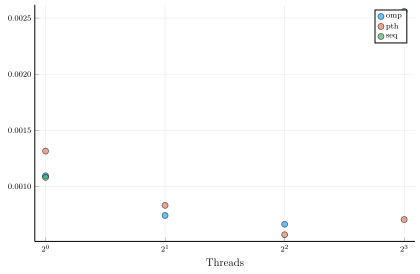

In [36]:

plot_results(data_full_picture.threads,
            data_full_picture.mean_duration_mono,
            data_full_picture.method,
            "",
            data_full_picture.method,
            max_thread_power = 10)

plot_results(data_seahorse_valley.threads,
            data_seahorse_valley.mean_duration_mono,
            data_seahorse_valley.method,
            "",
            data_seahorse_valley.method,
            max_thread_power = 10)



0x13 query result
threads │ method │ region │ size │ delta_x │ delta_y │ mean_duration_clock
────────┼────────┼────────┼──────┼─────────┼─────────┼────────────────────
... with 6 more columns: mean_duration_mono, mean_duration_sys, ci_duration_clock, ci_duration_mono, ci_duration_sys, repetitions